# Deep Learning Project | EfficiencyNetB7

In [2]:
# TensorFlow and Keras for model building
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Other utilities
import os
import numpy as np
import matplotlib.pyplot as plt


Constants

In [3]:
IMAGE_SIZE = 299
BATCH_SIZE = 32
CLASSES = 4
EPOCHS = 10

Dataset directory declaration

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C://Users//REYES//OneDrive//Desktop//CNN_Projects//DATASETS//AMPALAYA_DS", #Folder name or directory
shuffle=True,
image_size=(IMAGE_SIZE, IMAGE_SIZE),
batch_size=BATCH_SIZE
)

#Calls and Displays class names from dataset
class_names = dataset.class_names
class_names 

Found 2300 files belonging to 4 classes.


['Healthy',
 'Nitrogen Deficient',
 'Phosphorus Deficient',
 'Potassium Deficient']

# Splitting Dataset to 80-10-10, training, validation and test respectively

In [5]:
# Function for augmenting images using preprocessing layers
def augment(image):
    image = keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)(image)  # Randomly crop image
    image = keras.layers.RandomRotation(0.4)(image)  # Randomly rotate image
    image = keras.layers.RandomContrast(0.1)(image)  # Randomly adjust contrast
    image = keras.layers.RandomFlip("horizontal_and_vertical")(image)  # Randomly flip image
    image = keras.layers.RandomBrightness([0.1, 0.2])(image)  # Randomly adjust brightness

    return image

# Load and augment the training set
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000, augment_data=True):
    
    # Get length of dataset
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)  # Shuffle dataset before splitting
    
    # Compute percentage accordingly from dataset size
    train_size = int(train_split * ds_size) 
    val_size = int(val_split * ds_size) 
    
    # Split the dataset into training, validation, and test sets
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    if augment_data:
        # Apply augmentation only to the training set
        augmented_train_ds = train_ds.map(lambda x, y: (augment(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        
        # Concatenate the original training data with the augmented data
        train_ds = train_ds.concatenate(augmented_train_ds)
    
    return train_ds, val_ds, test_ds

# Assuming you already loaded your dataset into `dataset`
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Load EfficiencyNetB7 Model

In [6]:
# Load the pre-trained EfficientNetB7 model, without the top classification layers
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Add custom layers on top of EfficientNetB7 for leaf classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer to reduce dimensions

# Add a fully connected dense layer
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

In [7]:
# Add the final output layer for classification (number of classes)
predictions = Dense(4, activation='softmax')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# Freeze all layers in the base EfficientNetB7 model
for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 299, 299, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 299, 299, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 299, 299, 3)  0           ['normalization[0][0]']      

In [11]:
# Compile the model with an Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# #create a callback function to stop training when the validation loss does not improve
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


In [15]:
# Train the model on the dataset
history = model.fit(
    train_ds,
    epochs=EPOCHS,  # You can increase the number of epochs based on your dataset
    validation_data=val_ds,
    callbacks=[stop_early, lr_scheduler]
)


Epoch 1/10
114/114 [==============================] - 179s 922ms/step - loss: 0.4414 - accuracy: 0.8157 - val_loss: 0.2873 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 2/10
114/114 [==============================] - 99s 867ms/step - loss: 0.3488 - accuracy: 0.8503 - val_loss: 0.2701 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 3/10
114/114 [==============================] - 99s 867ms/step - loss: 0.3326 - accuracy: 0.8566 - val_loss: 0.2574 - val_accuracy: 0.9018 - lr: 0.0010
Epoch 4/10
114/114 [==============================] - 99s 869ms/step - loss: 0.3020 - accuracy: 0.8734 - val_loss: 0.1755 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 5/10
114/114 [==============================] - 98s 866ms/step - loss: 0.2633 - accuracy: 0.8959 - val_loss: 0.1820 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/10
114/114 [==============================] - 98s 864ms/step - loss: 0.2616 - accuracy: 0.8876 - val_loss: 0.2414 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 7/10
114/114 [==============================]

# Model Evualuation

In [16]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 33s 587ms/step - loss: 0.1813 - accuracy: 0.9297


In [21]:
# code to view f1 score and other metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

8/8 [==============================] - 5s 586ms/step
F1 Score: 0.6089773927380884
Precision: 0.6102728544776119
Recall: 0.609375
Accuracy: 0.609375
              precision    recall  f1-score   support

           0       0.57      0.63      0.60        60
           1       0.60      0.54      0.57        72
           2       0.64      0.64      0.64        61
           3       0.63      0.63      0.63        63

    accuracy                           0.61       256
   macro avg       0.61      0.61      0.61       256
weighted avg       0.61      0.61      0.61       256



In [35]:
# Unfreeze only a subset of layers
for layer in base_model.layers[:400]:  # Freeze the first 100 layers
    layer.trainable = False
for layer in base_model.layers[400:]:  # Unfreeze the rest
    layer.trainable = True

# Recompile the model for fine-tuning (with a lower learning rate)
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# resnet_model.compile(optimizer=RMSprop(learning_rate=0.0001), 
#                loss='sparse_categorical_crossentropy', 
#                metrics=['accuracy'])

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 299, 299, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 299, 299, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 299, 299, 3)  0           ['normalization[0][0]']      

8/8 [==============================] - 5s 578ms/step


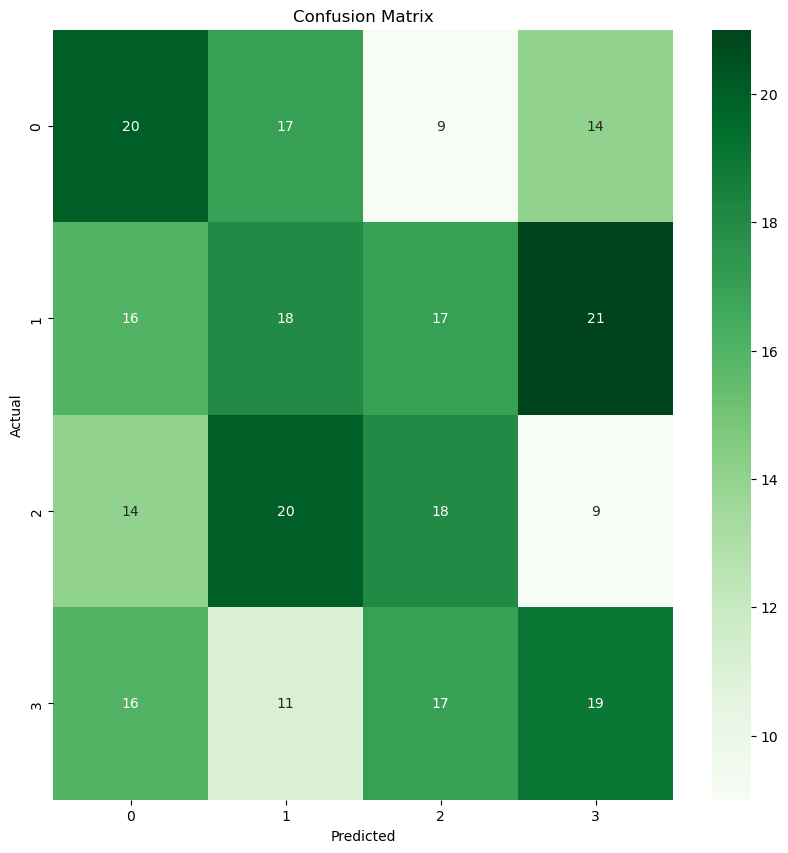

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [37]:
history_finetune = model.fit(
    train_ds,
    epochs=5,  # Additional epochs for fine-tuning
    batch_size = 32,
    validation_data=val_ds,
    callbacks=[stop_early, lr_scheduler]
)

Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'model/block5d_activation/Sigmoid' defined at (most recent call last):
    File "d:\anaconda3\envs\tf_gpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "d:\anaconda3\envs\tf_gpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "d:\anaconda3\envs\tf_gpu\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "d:\anaconda3\envs\tf_gpu\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "d:\anaconda3\envs\tf_gpu\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "d:\anaconda3\envs\tf_gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\REYES\AppData\Local\Temp\ipykernel_24296\1178403815.py", line 1, in <module>
      history_finetune = model.fit(
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\layers\core\activation.py", line 59, in call
      return self.activation(inputs)
    File "d:\anaconda3\envs\tf_gpu\lib\site-packages\keras\activations.py", line 276, in swish
      return tf.nn.silu(x)
Node: 'model/block5d_activation/Sigmoid'
failed to allocate memory
	 [[{{node model/block5d_activation/Sigmoid}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_192120]

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

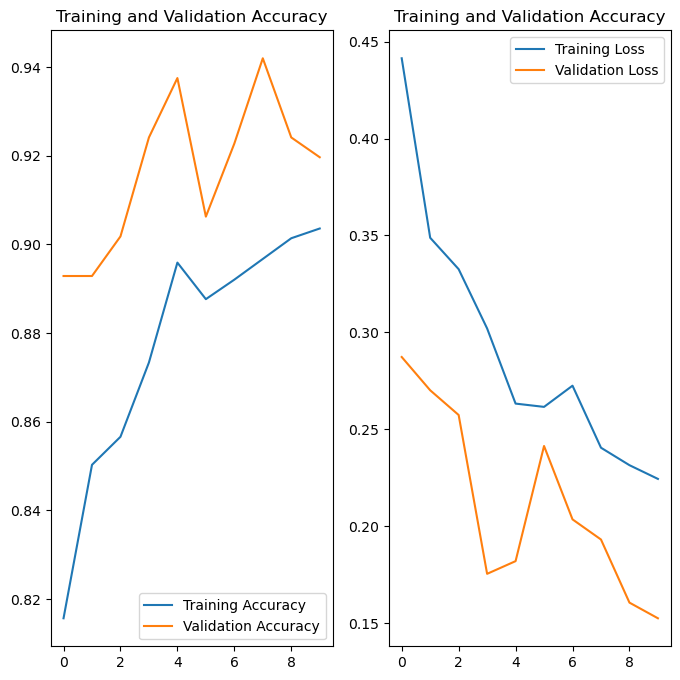

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

# Making a Prediction

Image to predict
Actual label:  Phosphorus Deficient
1/1 [==============================] - 6s 6s/step
Prediction:  Phosphorus Deficient


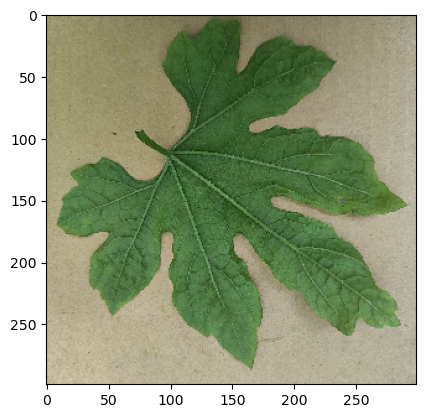

In [25]:
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print("Image to predict")
    plt.imshow(first_image)
    print("Actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Prediction: ", class_names[np.argmax(batch_prediction[0])])


Function for model prediction

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 63ms/step


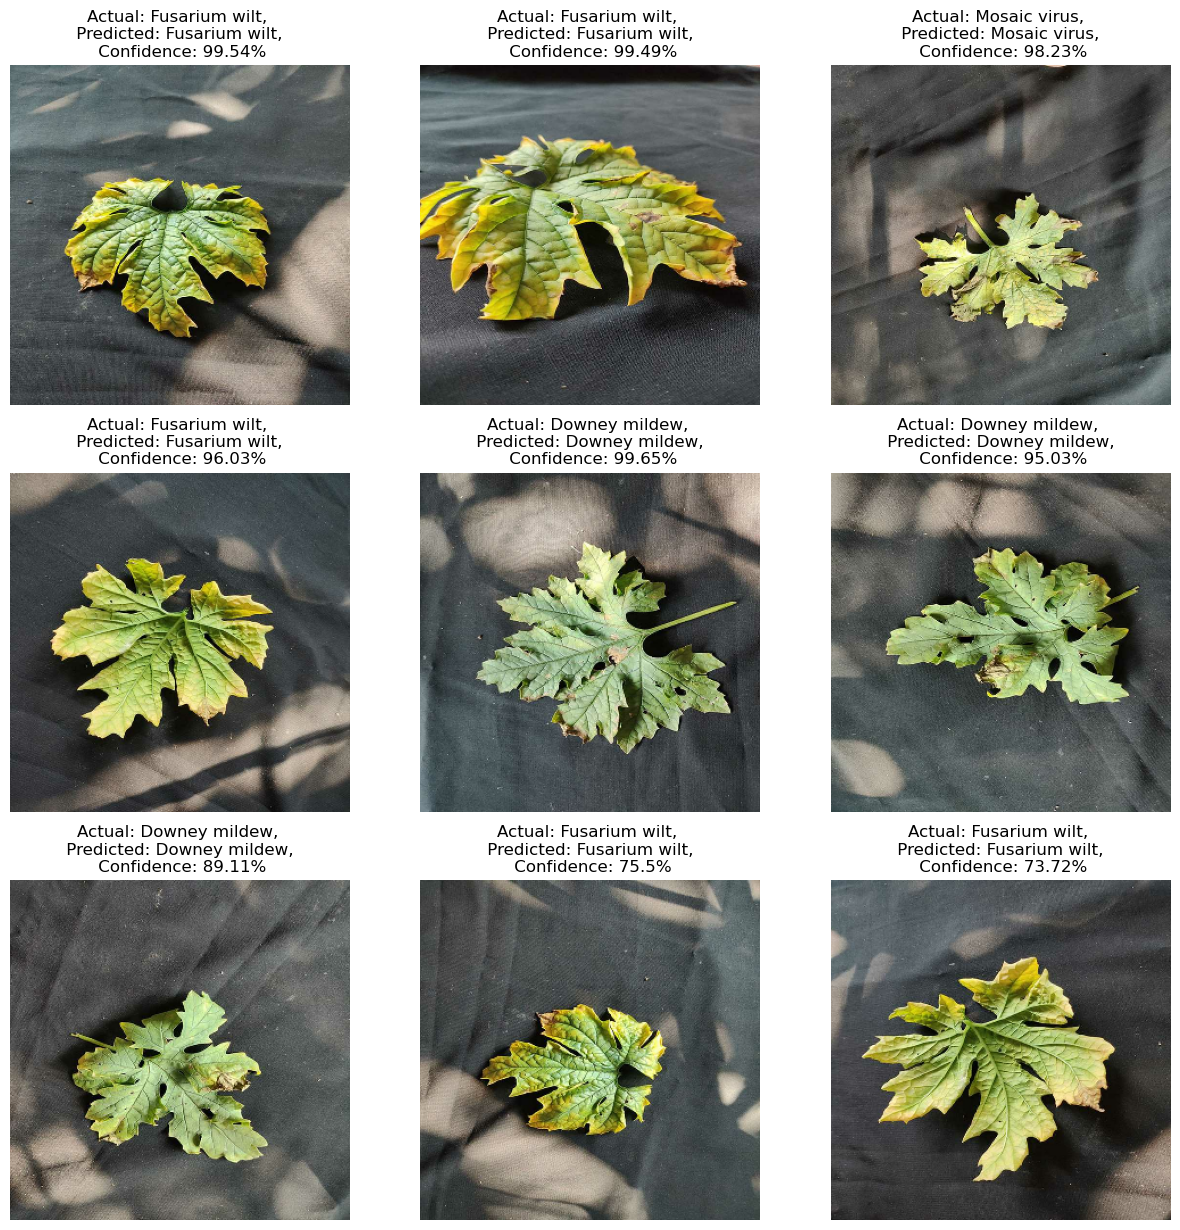

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving Model

In [47]:
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}", save_traces='tf')

INFO:tensorflow:Assets written to: 1.json\assets


INFO:tensorflow:Assets written to: 1.json\assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.